In [ ]:
%config InlineBackend.figure_formats = ['svg']
import os

STATIC_WEB_PAGE = {"EXECUTE_NB", "READTHEDOCS"}.intersection(os.environ)

```{autolink-concat}
```

# Speed up lambdifying

```{spec} Faster lambdification by splitting expressions
:id: TR-002
:status: Implemented
:tags: lambdification;sympy

This report has been implemented in {pr}`ComPWA/tensorwaves#281`.
```

<!-- cspell:disable -->

```{autolink-skip}
```

In [ ]:
%pip install -q ampform==0.9.1 numpy==1.19.5 pandas==1.2.4 pandas==1.2.4 qrules==0.8.2 sympy==1.8 tensorwaves==0.2.7

This notebook investigates how to speed up {func}`sympy.lambdify <sympy.utilities.lambdify.lambdify>` by splitting up the expression tree of a complicated expression into components, lambdifying those, and then combining them back again.

In [ ]:
from __future__ import annotations

import inspect
import logging
import timeit
import warnings
from typing import Callable, Generator, Sequence

import ampform
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qrules
import sympy as sp
from ampform.dynamics.builder import create_relativistic_breit_wigner_with_ff
from tensorwaves.data import generate_phsp
from tensorwaves.data.transform import HelicityTransformer
from tensorwaves.model import LambdifiedFunction, SympyModel

LOGGER = logging.getLogger()

## Create dummy expression

First, let's create an amplitude model with {mod}`ampform`. We'll use this model as complicated {class}`sympy.Expr <sympy.core.expr.Expr>` in the rest of this notebooks.

In [ ]:
LOGGER.setLevel(logging.ERROR)

In [ ]:
result = qrules.generate_transitions(
    initial_state=("J/psi(1S)", [-1, +1]),
    final_state=["gamma", "pi0", "pi0"],
    allowed_intermediate_particles=["f(0)(980)"],
    allowed_interaction_types=["strong", "EM"],
    formalism_type="canonical-helicity",
)
dot = qrules.io.asdot(
    result, collapse_graphs=True, render_final_state_id=False
)
graphviz.Source(dot)

In [ ]:
graphviz.Source(dot).render("002-f0(980)-graph", format="svg");

![](002-f0(980)-graph.svg)

In [ ]:
model_builder = ampform.get_builder(result)
for name in result.get_intermediate_particles().names:
    model_builder.set_dynamics(name, create_relativistic_breit_wigner_with_ff)
model = model_builder.generate()

In [ ]:
free_symbols = sorted(model.expression.free_symbols, key=lambda s: s.name)
free_symbols

[C[J/\psi(1S) \to f_{0}(980)_{0} \gamma_{+1}; f_{0}(980) \to \pi^{0}_{0} \pi^{0}_{0}],
 Gamma_f(0)(980),
 d_f(0)(980),
 m_1,
 m_12,
 m_2,
 m_f(0)(980),
 phi_1+2,
 phi_1,1+2,
 theta_1+2,
 theta_1,1+2]

## Helicity model components

A {class}`~ampform.helicity.HelicityModel` has the benefit that it comes with {attr}`~ampform.helicity.HelicityModel.components` (intensities and amplitudes) that together form its {attr}`~ampform.helicity.HelicityModel.expression`. Let's separate these components into _amplitude_ and _intensity_.

In [ ]:
amplitudes = {
    name: expr
    for name, expr in model.components.items()
    if name.startswith("A")
}
list(amplitudes)

['A[J/\\psi(1S)_{+1} \\to f_{0}(980)_{0} \\gamma_{-1,L=2,S=1}; f_{0}(980)_{0} \\to \\pi^{0}_{0} \\pi^{0}_{0,L=0,S=0}]',
 'A[J/\\psi(1S)_{+1} \\to f_{0}(980)_{0} \\gamma_{-1,L=0,S=1}; f_{0}(980)_{0} \\to \\pi^{0}_{0} \\pi^{0}_{0,L=0,S=0}]',
 'A[J/\\psi(1S)_{-1} \\to f_{0}(980)_{0} \\gamma_{-1,L=2,S=1}; f_{0}(980)_{0} \\to \\pi^{0}_{0} \\pi^{0}_{0,L=0,S=0}]',
 'A[J/\\psi(1S)_{-1} \\to f_{0}(980)_{0} \\gamma_{-1,L=0,S=1}; f_{0}(980)_{0} \\to \\pi^{0}_{0} \\pi^{0}_{0,L=0,S=0}]',
 'A[J/\\psi(1S)_{-1} \\to f_{0}(980)_{0} \\gamma_{+1,L=2,S=1}; f_{0}(980)_{0} \\to \\pi^{0}_{0} \\pi^{0}_{0,L=0,S=0}]',
 'A[J/\\psi(1S)_{-1} \\to f_{0}(980)_{0} \\gamma_{+1,L=0,S=1}; f_{0}(980)_{0} \\to \\pi^{0}_{0} \\pi^{0}_{0,L=0,S=0}]',
 'A[J/\\psi(1S)_{+1} \\to f_{0}(980)_{0} \\gamma_{+1,L=2,S=1}; f_{0}(980)_{0} \\to \\pi^{0}_{0} \\pi^{0}_{0,L=0,S=0}]',
 'A[J/\\psi(1S)_{+1} \\to f_{0}(980)_{0} \\gamma_{+1,L=0,S=1}; f_{0}(980)_{0} \\to \\pi^{0}_{0} \\pi^{0}_{0,L=0,S=0}]']

In [ ]:
intensities = {
    name: expr
    for name, expr in model.components.items()
    if name.startswith("I")
}

In [ ]:
assert len(amplitudes) + len(intensities) == len(model.components)

### Component structure

Note that each intensity consists of a subset of these amplitudes. This means that _intensities have a larger expression tree than amplitudes_.

In [ ]:
amplitude_to_symbol = {
    expr: sp.Symbol(f"A{i}") for i, expr in enumerate(amplitudes.values(), 1)
}

In [ ]:
intensity_to_symbol = {
    expr: sp.Symbol(f"I{i}") for i, expr in enumerate(intensities.values(), 1)
}

In [ ]:
intensity_expr = model.expression.subs(intensity_to_symbol, simultaneous=True)
intensity_expr

I1 + I2 + I3 + I4

In [ ]:
dot = sp.dotprint(intensity_expr)
graphviz.Source(dot)

In [ ]:
graphviz.Source(dot).render("002-collapsed-expression-tree", format="svg");

![](002-collapsed-expression-tree.svg)

In [ ]:
amplitude_expr = model.expression.subs(amplitude_to_symbol, simultaneous=True)
amplitude_expr

Abs(A1 + A2)**2 + Abs(A3 + A4)**2 + Abs(A5 + A6)**2 + Abs(A7 + A8)**2

In [ ]:
dot = sp.dotprint(amplitude_expr)
graphviz.Source(dot)

In [ ]:
graphviz.Source(dot).render("002-simple-expression-tree", format="svg");

![](002-simple-expression-tree.svg)

### Performance check

Lambdifying the whole {attr}`HelicityModel.expression <ampform.helicity.HelicityModel.expression>` is slowest. The {func}`~sympy.utilities.lambdify.lambdify` function first prints the expression as a {obj}`str` (!) with (in this case) {mod}`numpy` syntax and then uses {func}`eval` to convert that back to actual {mod}`numpy` objects:

:::{margin}

We store the time with {mod}`timeit` for section {ref}`report/002:Arbitrary expressions`.

:::

In [ ]:
runtime = {}
start = timeit.default_timer()

```{autolink-skip}
```

In [ ]:
%%time
np_complete_model = sp.lambdify(free_symbols, model.expression.doit(), "numpy")

CPU times: user 1.46 s, sys: 703 µs, total: 1.46 s
Wall time: 1.46 s


In [ ]:
stop = timeit.default_timer()
runtime["complete model"] = stop - start

Printing to {obj}`str` and converting back with {func}`eval` becomes exponentially slow the larger the expression tree. This means that it's more efficient to lambdify sub-trees of the expression tree separately. Lambdifying the four _intensities_ of this model separately, the effect is not noticeable:

In [ ]:
LOGGER.setLevel(logging.INFO)

```{autolink-skip}
```

In [ ]:
%%time
for expr, symbol in intensity_to_symbol.items():
    logging.info(f"Lambdifying {symbol.name}")
    start = timeit.default_timer()
    sp.lambdify(free_symbols, expr.doit(), "numpy")
    stop = timeit.default_timer()
    runtime[symbol.name] = stop - start

INFO:root:Lambdifying I1
INFO:root:Lambdifying I2
INFO:root:Lambdifying I3
INFO:root:Lambdifying I4


CPU times: user 1.56 s, sys: 4.94 ms, total: 1.56 s
Wall time: 1.56 s


...but each of the eight _amplitudes_ separately does result in a significant speed-up:

```{autolink-skip}
```

In [ ]:
%%time
np_amplitudes = {}
for expr, symbol in amplitude_to_symbol.items():
    logging.info(f"Lambdifying {symbol.name}")
    start = timeit.default_timer()
    np_expr = sp.lambdify(free_symbols, expr.doit(), "numpy")
    stop = timeit.default_timer()
    runtime[symbol.name] = stop - start
    np_amplitudes[symbol] = np_expr

INFO:root:Lambdifying A1
INFO:root:Lambdifying A2
INFO:root:Lambdifying A3
INFO:root:Lambdifying A4
INFO:root:Lambdifying A5
INFO:root:Lambdifying A6
INFO:root:Lambdifying A7
INFO:root:Lambdifying A8


CPU times: user 547 ms, sys: 3.85 ms, total: 550 ms
Wall time: 547 ms


### Recombining components

{ref}`Recall <report/002:Component structure>` what amplitude module expressed in its amplitude components looks like:

In [ ]:
amplitude_expr

Abs(A1 + A2)**2 + Abs(A3 + A4)**2 + Abs(A5 + A6)**2 + Abs(A7 + A8)**2

We have to lambdify that top expression as well:

In [ ]:
sorted_amplitude_symbols = sorted(np_amplitudes, key=lambda s: s.name)
np_amplitude_expr = sp.lambdify(
    sorted_amplitude_symbols, amplitude_expr, "numpy"
)

In [ ]:
source = inspect.getsource(np_amplitude_expr)
print(source)

def _lambdifygenerated(A1, A2, A3, A4, A5, A6, A7, A8):
    return (abs(A1 + A2)**2 + abs(A3 + A4)**2 + abs(A5 + A6)**2 + abs(A7 + A8)**2)



We now have a lambdified expression for the complete amplitude model, as well as lambdified expressions that are to be plugged in to its arguments.

In [ ]:
def componentwise_lambdified(*args):
    """Lambdified amplitude model, recombined from its amplitude components.

    .. warning:: Order of the ``args`` has to be the same as that
        of the ``args`` of the lambdified amplitude components.
    """
    amplitude_values = []
    for amp_symbol in sorted_amplitude_symbols:
        np_amplitude = np_amplitudes[amp_symbol]
        values = np_amplitude(*args)
        amplitude_values.append(values)
    return np_amplitude_expr(*amplitude_values)

### Test with data

Okay, so does all this work? Let's first generate a phase space sample with good-old {mod}`tensorwaves`. We can then use this sample as input to the component-wise lambdified function.

In [ ]:
LOGGER.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [ ]:
sympy_model = SympyModel(
    expression=model.expression,
    parameters=model.parameter_defaults,
)
intensity = LambdifiedFunction(sympy_model, backend="jax")
data_converter = HelicityTransformer(model.adapter)
phsp_sample = generate_phsp(10_000, model.adapter.reaction_info)
phsp_set = data_converter.transform(phsp_sample)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(phsp_set["m_12"], bins=50, alpha=0.5, density=True)
ax.hist(
    phsp_set["m_12"],
    bins=50,
    alpha=0.5,
    density=True,
    weights=intensity(phsp_set),
)
plt.show()

In [ ]:
fig.savefig("002-histogram-m12.svg");

![](002-histogram-m12.svg)

The arguments of the component-wise lambdified amplitude model should be covered by the entries in the phase space set and the provided parameter defaults:

In [ ]:
kinematic_variable_names = {key for key in phsp_set}
parameter_names = {symbol.name for symbol in model.parameter_defaults}
free_symbol_names = {symbol.name for symbol in free_symbols}

In [ ]:
assert free_symbol_names <= kinematic_variable_names ^ parameter_names

That allows us to sort the input arrays and parameter defaults so that they can be used as positional argument input to the component-wise lambdified amplitude model:

In [ ]:
merged_par_var_values = {
    symbol.name: value for symbol, value in model.parameter_defaults.items()
}
merged_par_var_values.update(phsp_set)
args_values = [merged_par_var_values[symbol.name] for symbol in free_symbols]

Finally, here's the result of plugging that back into the component-wise lambdified expression:

In [ ]:
componentwise_result = componentwise_lambdified(*args_values)
componentwise_result

array([0.03229431, 0.00087071, 0.01893205, ..., 0.01543035, 0.00925805,
       0.00019983])

And it's indeed the same as that the intensity computed by {mod}`tensorwaves` (direct lambdify):

In [ ]:
tensorwaves_result = np.array(intensity(phsp_set))
mean_difference = (componentwise_result - tensorwaves_result).mean()
mean_difference

2.576638731189573e-10

In [ ]:
assert mean_difference < 1e-9

## Arbitrary expressions

The problem with {ref}`report/002:Test with data` is that it requires a {obj}`~ampform.helicity.HelicityModel`. In {mod}`tensorwaves`, we want to work with general {class}`sympy.Expr <sympy.core.expr.Expr>`s though (see [`SympyModel`](https://tensorwaves.readthedocs.io/en/0.2.7/api/tensorwaves.model.html#tensorwaves.model.SympyModel)), where we don't have sub-{attr}`ampform.helicity.HelicityModel.components` available.

Instead, we have to split up the lambdifying in a more general way that can handle arbitrary {class}`sympy.core.expr.Expr`s. For that we need:

1. A general method of traversing through a SymPy expression tree. This can be done with {doc}`sympy:tutorial/manipulation`.
2. A **fast** method to estimate the complexity of a model, so that we can decide whether a node in the expression tree is small enough to be lambdified without much runtime. The best measure for complexity is {func}`~sympy.core.function.count_ops` ("count operations"), see notes under {doc}`sympy:modules/simplify/simplify`.

### Expression complexity

Let's tackle 2. first and use the {attr}`HelicityModel.expression <ampform.helicity.HelicityModel.expression>` and its {attr}`~ampform.helicity.HelicityModel.components` that we lambdified earlier on. Here's an overview of the number of operations versus the time it took to lambdify each component:

In [ ]:
df = pd.DataFrame(runtime.values(), index=runtime, columns=["runtime (s)"])
operations = [sp.count_ops(model.expression)]
operations.extend(sp.count_ops(expr) for expr in intensity_to_symbol)
operations.extend(sp.count_ops(expr) for expr in amplitude_to_symbol)
df.insert(0, "operations", operations)
df

,operations,runtime (s)
complete model,823,1.471643
I1,207,0.342924
I2,209,0.333298
I3,203,0.352337
I4,201,0.530211
A1,102,0.105574
A2,102,0.058180
A3,103,0.064527
A4,103,0.060311
A5,100,0.062091


From this we can already roughly see that the lambdify runtime scales roughly with the number of SymPy operations.

To better visualize this, we can lambdify the expressions in {class}`~ampform.dynamics.BlattWeisskopfSquared` for each angular momentums and compute their runtime a number of times with {mod}`timeit`. Note that the {class}`~ampform.dynamics.BlattWeisskopfSquared` becomes increasingly complex the higher the angular momentum.

In [ ]:
from ampform.dynamics import BlattWeisskopfSquared

angular_momentum, z = sp.symbols("L z")
BlattWeisskopfSquared(angular_momentum, z).doit()

Piecewise((1, Eq(L, 0)), (2*z/(z + 1), Eq(L, 1)), (13*z**2/(9*z + (z - 3)**2), Eq(L, 2)), (277*z**3/(z*(z - 15)**2 + (2*z - 5)*(18*z - 45)), Eq(L, 3)), (12746*z**4/(25*z*(2*z - 21)**2 + (z**2 - 45*z + 105)**2), Eq(L, 4)), (998881*z**5/(z**5 + 15*z**4 + 315*z**3 + 6300*z**2 + 99225*z + 893025), Eq(L, 5)), (118394977*z**6/(z**6 + 21*z**5 + 630*z**4 + 18900*z**3 + 496125*z**2 + 9823275*z + 108056025), Eq(L, 6)), (19727003738*z**7/(z**7 + 28*z**6 + 1134*z**5 + 47250*z**4 + 1819125*z**3 + 58939650*z**2 + 1404728325*z + 18261468225), Eq(L, 7)), (4392846440677*z**8/(z**8 + 36*z**7 + 1890*z**6 + 103950*z**5 + 5457375*z**4 + 255405150*z**3 + 9833098275*z**2 + 273922023375*z + 4108830350625), Eq(L, 8)))

In [ ]:
operations = []
runtime = []
for angular_momentum in range(9):
    ff2 = BlattWeisskopfSquared(angular_momentum, z)
    operations.append(sp.count_ops(ff2.doit()))
    n_iterations = 10
    t = timeit.timeit(
        setup=f"""
import sympy as sp
from ampform.dynamics import BlattWeisskopfSquared
z = sp.Symbol("z")
ff2 = BlattWeisskopfSquared({angular_momentum}, z)
    """,
        stmt='sp.lambdify(z, ff2.doit(), "numpy")',
        number=n_iterations,
    )
    runtime.append(t / n_iterations * 1_000)

In [ ]:
df = pd.DataFrame(
    {
        "operations": operations,
        "runtime (ms)": runtime,
    },
)
df

,operations,runtime (ms)
0,0,0.647902
1,3,1.629346
2,7,1.780732
3,12,3.248333
4,14,2.890283
5,16,2.249974
6,19,2.533441
7,22,2.737607
8,25,2.913332


In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(x=df["operations"], y=df["runtime (ms)"])
ax.set_ylim(bottom=0)
ax.set_xlabel("operations")
ax.set_ylabel("runtime (ms)")
plt.show()

In [ ]:
fig.savefig("002-runtime-vs-operations.svg");

![](002-runtime-vs-operations.svg)

### Identifying nodes

Now imagine that we don't know anything about the {attr}`~ampform.helicity.HelicityModel.expression` that we created before other than that it is a {class}`sympy.Expr <sympy.core.expr.Expr>`.

#### Approach 1: Generator

A first attempt is to use a generator to recursively identify components in the expression that lie within a certain 'complexity' (as computed by {func}`~sympy.core.function.count_ops`).

In [ ]:
def recurse_tree(
    expression: sp.Expr, *, min_complexity: int = 0, max_complexity: int
) -> Generator[sp.Expr, None, None]:
    for arg in expression.args:
        complexity = sp.count_ops(arg)
        if complexity < max_complexity and complexity > min_complexity:
            yield arg
        else:
            yield from recurse_tree(
                arg,
                min_complexity=min_complexity,
                max_complexity=max_complexity,
            )

We can then use this generator function to create a mapping of these sub-expressions within the expression tree to {class}`~sympy.core.symbol.Symbol`s. That mapping can then be used in {meth}`~sympy.core.basic.Basic.xreplace` to replace the sub-expressions with those symbols.

:::{margin}

The {meth}`~sympy.core.basic.Basic.xreplace` method is **much faster** than {meth}`~sympy.core.basic.Basic.subs`, because it doesn't do any evaluation.

:::

```{autolink-skip}
```

In [ ]:
%%time
expression = model.expression.doit()
sub_expressions = {}
for i, expr in enumerate(recurse_tree(expression, max_complexity=100)):
    symbol = sp.Symbol(f"f{i}")
    complexity = sp.count_ops(expr)
    sub_expressions[expr] = symbol
expression.xreplace(sub_expressions)

CPU times: user 314 ms, sys: 135 µs, total: 314 ms
Wall time: 313 ms


Abs(f0 + f1)**2 + Abs(f2 + f3)**2 + Abs(f4 + f5)**2 + Abs(f6 + f7)**2

#### Approach 2: Direct substitution

There is one problem though: {meth}`~sympy.core.basic.Basic.xreplace` is not accurate for larger expressions. It would therefore be better to directly substitute the sub-expression with a symbol while we loop over the nodes in the expression tree. The following function can do that:

In [ ]:
def split_expression(
    expression: sp.Expr,
    max_complexity: int,
    min_complexity: int = 0,
) -> tuple[sp.Expr, dict[sp.Symbol, sp.Expr]]:
    i = 0
    symbol_mapping = {}

    def recursive_split(sub_expression: sp.Expr) -> sp.Expr:
        nonlocal i
        for arg in sub_expression.args:
            complexity = sp.count_ops(arg)
            if complexity < max_complexity and complexity > min_complexity:
                symbol = sp.Symbol(f"f{i}")
                i += 1
                symbol_mapping[symbol] = arg
                sub_expression = sub_expression.xreplace({arg: symbol})
            else:
                new_arg = recursive_split(arg)
                sub_expression = sub_expression.xreplace({arg: new_arg})
        return sub_expression

    top_expression = recursive_split(expression)
    return top_expression, symbol_mapping

And indeed, this is **much faster** than {ref}`report/002:Approach 1: Generator` (it's even possible to parallelize this for loop):

```{autolink-skip}
```

In [ ]:
%time
top_expression, sub_expressions = split_expression(
    expression, max_complexity=100
)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 15.5 µs


In [ ]:
top_expression

Abs(f0 + f1)**2 + Abs(f2 + f3)**2 + Abs(f4 + f5)**2 + Abs(f6 + f7)**2

In [ ]:
sub_expressions[sp.Symbol("f0")]

C[J/\psi(1S) \to f_{0}(980)_{0} \gamma_{+1}; f_{0}(980) \to \pi^{0}_{0} \pi^{0}_{0}]*Gamma_f(0)(980)*m_f(0)(980)*(cos(theta_1+2)/2 + 1/2)*exp(I*phi_1+2)/(-I*Gamma_f(0)(980)*m_f(0)(980)*sqrt((m_12**2 - (m_1 - m_2)**2)*(m_12**2 - (m_1 + m_2)**2)/m_12**2)*sqrt(m_f(0)(980)**2)/(sqrt((m_f(0)(980)**2 - (m_1 - m_2)**2)*(m_f(0)(980)**2 - (m_1 + m_2)**2)/m_f(0)(980)**2)*Abs(m_12)) - m_12**2 + m_f(0)(980)**2)

### Lambdify and combine

Now that we have the machinery to split up arbitrary expressions by complexity, we need to lambdify the top expression as well as each of the sub-expressions and recombine them. The following function can do that and return a recombined {class}`~typing.Callable`.

In [ ]:
def optimized_lambdify(
    args: Sequence[sp.Symbol],
    expr: sp.Expr,
    modules: str | None = None,
    min_complexity: int = 0,
    max_complexity: int = 100,
) -> Callable:
    top_expression, definitions = split_expression(
        expression,
        min_complexity=min_complexity,
        max_complexity=max_complexity,
    )
    top_symbols = sorted(definitions, key=lambda s: s.name)
    top_lambdified = sp.lambdify(top_symbols, top_expression, modules)
    sub_lambdified = [
        sp.lambdify(args, definitions[symbol], modules)
        for symbol in top_symbols
    ]

    def recombined_function(*args):
        new_args = [sub_expr(*args) for sub_expr in sub_lambdified]
        return top_lambdified(*new_args)

    return recombined_function

We can use the same input values as in {ref}`report/002:Test with data` to check that the resulting lambdified expression results in the same output.

```{autolink-skip}
```

In [ ]:
%time
treewise_lambdified = optimized_lambdify(free_symbols, expression, "numpy")

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 17.4 µs


In [ ]:
treewise_result = treewise_lambdified(*args_values)
treewise_result

array([0.03229431, 0.00087071, 0.01893205, ..., 0.01543035, 0.00925805,
       0.00019983])

And it's indeed the same as that the intensity computed by {mod}`tensorwaves` (direct lambdify):

In [ ]:
mean_difference = (treewise_result - tensorwaves_result).mean()
mean_difference

2.576638734685813e-10

In [ ]:
assert mean_difference < 1e-9

## Comparison

Now have a look at a slightly more complicated model:

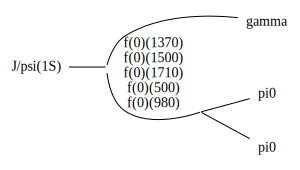

In [ ]:
result = qrules.generate_transitions(
    initial_state=("J/psi(1S)", [+1]),
    final_state=["gamma", "pi0", "pi0"],
    allowed_intermediate_particles=["f(0)"],
    allowed_interaction_types=["strong", "EM"],
    formalism_type="canonical-helicity",
)
model_builder = ampform.get_builder(result)
for name in result.get_intermediate_particles().names:
    model_builder.set_dynamics(name, create_relativistic_breit_wigner_with_ff)
complex_model = model_builder.generate()
dot = qrules.io.asdot(
    result, collapse_graphs=True, render_final_state_id=False
)
graphviz.Source(dot)

In [ ]:
graphviz.Source(dot).render("002-f0-graph", format="svg");

![](002-f0-graph.svg)

This makes it clear that the functions defined in {ref}`report/002:Arbitrary expressions` results in a huge speed-up!

In [ ]:
new_expression = complex_model.expression.doit()
new_free_symbols = sorted(new_expression.free_symbols, key=lambda s: s.name)

```{autolink-skip} section
```

In [ ]:
%%time
np_expr = sp.lambdify(new_free_symbols, new_expression)

CPU times: user 4.57 s, sys: 3.16 ms, total: 4.57 s
Wall time: 4.57 s


In [ ]:
%%time
np_expr = optimized_lambdify(new_free_symbols, new_expression)

CPU times: user 261 ms, sys: 87 µs, total: 262 ms
Wall time: 260 ms
